In [186]:
from cvxpylayers.torch import CvxpyLayer
import torch
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

torch.set_default_dtype(torch.double)

## Differentiable optimal transport

Suppose we have two one-dimensional probability distributions, $\nu$ and $\eta$, defined
by their supports $x\in\mathbf{R}^n$, $y\in\mathbf{R}^m$, and probability weight vectors $a\in\mathbf{R}_+^n$, $b\in\mathbf{R}_+^m$.
That is, $\nu=x_i$ with probability $a_i$, and
$\eta=y_j$ with probability $b_j$.

In optimal transport, the goal is to find a matrix $P\in\mathbf{R}_+^{n\times m}$ (the set of nonnegative $n$ by $m$ matrices) that *transports*
$\nu$ into $\eta$. The entry $P_{ij}$ tells us how much of the probability mass at $x_i$
that we transfer to $y_j$. We have two constraints:
* $\sum_{j} P_{ij} = a_i$, $i=1,\ldots,n$, which requires that the mass leaving $x_i$ is equal to the mass available, $a_i$.
* $\sum_{i} P_{ij} = b_j$, $j=1,\ldots,m$, which requires that the mass entering $y_i$ is equal to the mass there, $b_j$.

For each mass transfer $P_{ij}$, we associate a cost $C_{ij} = h(x_i - y_j)$, where $h(d)$ measures
the cost of transferring a unit a distance $d$. An example is $h(d)=d^2$; in this case $C_{ij}$ measures
the squared difference between $x_i$ and $y_j$.

We can find the (regularized) optimal transport between $\nu$ and $\eta$ by solving the optimization problem
\begin{equation}
\begin{array}{ll}
\mbox{minimize} & \mathbf{tr}(C^TP) - \varepsilon H(P), \\
\mbox{subject to} & P \in \mathbf{R}_+^{n \times m}, \\
& P\mathbf{1}=a, \quad P^T\mathbf{1}=b.
\end{array}
\end{equation}
where $H(P) = -\sum_{ij} P_{ij} (\log(P_{ij}) - 1)$ is an entropy regularization function and $\varepsilon > 0$ is a hyper-parameter.
This is a convex optimization problem.

See:
Leonid Kantorovich. On the transfer of masses (in russian). Doklady Akademii Nauk, 37(2): 227–229, 1942

In [187]:
def get_regularized_ot(n, m):
    C = cp.Parameter((n, m))
    a = cp.Parameter(n)
    b = cp.Parameter(m)
    P = cp.Variable((n, m))
    eps = cp.Parameter(1, nonneg=True)

    H = lambda P: cp.sum(cp.entr(P)) + cp.sum(P)
    objective = cp.trace(P.T @ C) - eps * H(P)

    prob = cp.Problem(cp.Minimize(objective), [P@np.ones(m) == a, P.T@np.ones(n) == b, P >= 0])

    layer = CvxpyLayer(prob, [C, a, b, eps], [P])
    def f(x, y, a, b, eps, h=lambda d: d.pow(2)):
        """Regularized optimal transport.

        x: n-vector
        y: m-vector
        a: n-vector of probabilities
        b: m-vector of probabilities
        eps: scalar, amount of regularization
        """
        C = h(x[:,None] - y[None,:])
        return layer(C, a, b, eps)[0]
    return f

### Example

In [188]:
n, m = 3, 3
regularized_ot = get_regularized_ot(n, m)

In [189]:
torch.manual_seed(6)
x = torch.randn(n, requires_grad=True)
y = torch.randn(m, requires_grad=True)
a = torch.full((n,), 1./n, requires_grad=True)
b = torch.full((m,), 1./m, requires_grad=True)
eps = torch.tensor([1.], requires_grad=True)

<BarContainer object of 3 artists>

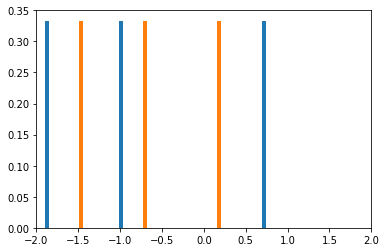

In [190]:
plt.xlim(-2,2)
plt.bar(x.detach().numpy(), a.detach().numpy(), width=.05)
plt.bar(y.detach().numpy(), b.detach().numpy(), width=.05)

In [191]:
P = regularized_ot(x, y, a, b, eps)

WARN: aa_init returned NULL, no acceleration applied.


In [192]:
x

tensor([-1.8744, -0.9937,  0.7185], requires_grad=True)

In [193]:
y

tensor([-0.6985, -1.4716,  0.1777], requires_grad=True)

In [194]:
print(P)

tensor([[0.1007, 0.2269, 0.0058],
        [0.1807, 0.1043, 0.0483],
        [0.0520, 0.0021, 0.2792]], grad_fn=<_CvxpyLayerFnFnBackward>)


In [195]:
# What would we have to do to increase the mass that we transfer from x = .7185 to y=.1777
P[2,2].backward()

In [196]:
# increase x[2] and decrease x[0:2]
x.grad

tensor([-0.0010, -0.0401,  0.0411])

In [197]:
# increase y[2] and decrease y[0], but increase y[1]?
y.grad

tensor([-0.0826,  0.0007,  0.0819])